<a href="https://colab.research.google.com/github/Amartya-pixel/My-code-page/blob/master/Copy_of_cs6910_assignment1v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing required packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#importing datasets
from keras.datasets import fashion_mnist
(x_train,y_train), (x_test,y_test) = fashion_mnist.load_data()
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.1,shuffle=True)

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [6]:
X_train = np.float128(x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2]).T)
Y_train = np.float128(pd.get_dummies(y_train).T)

X_test = np.float128(x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2]).T)
Y_test = np.float128(pd.get_dummies(y_test).T)

X_val = np.float128(x_val.reshape(x_val.shape[0],x_val.shape[1]*x_val.shape[2]).T)
Y_val = np.float128(pd.get_dummies(y_val).T)

In [7]:
class FeedForwardNN:
  def __init__(self,config=None,epochs=5,hidden_layers=[64,64,64],weight_decay=0,learning_rate=1e-3,optimizer='sgd',batch_size=16,weight_initialization='random',activations='sigmoid',loss_function='cross-entropy',output_function='softmax',gamma=0.9,beta=0.9,beta1=0.9,beta2=0.999,eps=1e-8):
    if config is not None:
      self.epochs = config["epochs"]
      self.learning_rate = config["learning_rate"]
      self.weight_decay = config["weight_decay"]
      self.optimizer = config["optimizer"]
      self.batch_size = config["batch_size"]
      self.weight_initialization = config["weight_initialization"]
      self.activations = config["activations"]
      self.hidden_layers = [config["hidden_layers_size"] for x in range(config["no_hidden_layers"])]
    else:
      self.epochs = epochs
      self.learning_rate = learning_rate
      self.weight_decay = weight_decay
      self.optimizer = optimizer
      self.batch_size = batch_size
      self.weight_initialization = weight_initialization
      self.activations = activations
      self.hidden_layers = hidden_layers

    self.loss_function = loss_function
    self.output_function = output_function
    self.gamma = gamma
    self.beta = beta
    self.beta1 = beta1
    self.beta2 = beta2
    self.eps = eps

    self.initialize()


  def sigmoid(self,x):
    return 1.0 / (1.0 + np.exp(-x))
    
  def tanh(self,x):
    return np.tanh(x)

  def ReLu(self,x):
    p = np.vectorize(lambda a: max(0,a))
    return p(x)

  def d_sigmoid(self,x):
    return self.sigmoid(x)*(1.0 - self.sigmoid(x))
  def d_tanh(self,x):
    return 1.0 - self.tanh(x)*self.tanh(x) 

  def d_ReLu(self,x):
    return 1*(x>0)

  def activation(self,x,n='sigmoid'):
    if n == 'sigmoid':
      return self.sigmoid(x)
    elif n == 'tanh':
      return self.tanh(x)
    elif n == 'ReLu':
      return self.ReLu(x)

  def d_activation(self,x,n='sigmoid'):
    if n == 'sigmoid':
      return self.d_sigmoid(x)
    elif n == 'tanh':
      return self.d_tanh(x)
    elif n=='ReLu':
      return self.d_ReLu(x)


  def softmax(self,x):
    e = np.exp(x)
    return e / np.sum(e,axis=0)

  def output(self,x,n='softmax'):
    if n == 'softmax':
      return self.softmax(x)

  def cross_error(self,Y,inputs):
    Y_hat = inputs[1][-1]
    return -1*np.sum(Y*(np.log(Y_hat)))

  def error(self,Y,inputs,n='cross-entropy'):
    if n == 'cross-entropy':
      return self.cross_error(Y,inputs)
  
  def cross_error_val(self,Y,inputs):
    W,B = self.theta
    Y_hat = inputs[1][-1]
    m = Y.shape[1]
    return (-1/m)*np.sum(Y*(np.log(Y_hat))) + (self.lambd/(2*m))*(self.frobenius(W**2) + self.frobenius(B**2))

  def val_error(self,Y,inputs,n='cross-entropy'):
    if n == 'cross-entropy':
      return self.cross_error_val(Y,inputs)

  def random_initialize_parameters(self,n,layers):
    L = len(layers)
    biases = []
    weights = []
    for i in range(L):
      bias = np.float128(np.zeros((layers[i],1)))
      if i == 0:
        weight = np.float128(np.random.randn(layers[i],n))
      else:
        weight = np.float128(np.random.randn(layers[i],layers[i-1]))
      biases.append(bias)
      weights.append(weight)
    return (np.array(weights),np.array(biases))
  
  def Xavier_initialize_parameters(self,n,layers):
     L=len(layers)
     biases = []
     weights = []
     for i in range(L):
       bias=np.float128(np.zeros((layers[i], 1)))
       if i==0:
         weight=np.float128(np.random.randn(layers[i],n))
       else:
         weight = np.float128(np.random.randn(layers[i],layers[i - 1]) * np.sqrt(1 / layers[i - 1]))
       biases.append(bias)
       weights.append(weight)

     return (np.array(weights),np.array(biases))



  def initialize_parameters(self,n,layers,t):
    if t == 'random':
      return self.random_initialize_parameters(n,layers)
    elif t == 'Xavier':
      return self.Xavier_initialize_parameters(n,layers)
  
  def update_theta(self,theta,d_theta,learning_rate):
    weights, biases = theta
    d_weights,d_biases = d_theta
    weights = (1 - self.weight_decay)*weights - learning_rate*d_weights
    biases = (1 - self.weight_decay)*biases - learning_rate*d_biases
    return (weights,biases)

  def update_theta_momentum(self,theta,d_theta,learning_rate,gamma,prev_weight,prev_bias):
    weights, biases = theta
    d_weights,d_biases = d_theta
    v_weight=gamma*prev_weight+learning_rate*d_weights
    v_bias=gamma*prev_bias+learning_rate*d_biases
    weights = (1 - self.weight_decay)*weights - v_weight
    biases = (1 - self.weight_decay)*biases - v_bias
    return (weights,biases,v_weight,v_bias) 

  def update_theta_nestrov(self,theta,d_theta,learning_rate,gamma,prev_weight,prev_bias):
    weights, biases = theta
    d_weights,d_biases = d_theta
    v_weight=gamma*prev_weight+learning_rate*d_weights
    v_bias=gamma*prev_bias+learning_rate*d_biases
    weights = (1 - self.weight_decay)*weights - v_weight
    biases = (1 - self.weight_decay)*biases - v_bias
    return (weights,biases,v_weight,v_bias)

  def update_theta_rms_prop(self,theta,d_theta,d_theta2,prev_weights2,prev_biases2,learning_rate,beta,eps):
    weights, biases = theta
    d_weights,d_biases = d_theta
    d_weights2,d_biases2 = d_theta2

    prev_weights2=beta*prev_weights2 + (1-beta)*d_weights2
    prev_biases2=beta*prev_biases2 + (1-beta)*d_biases2

    W_ = learning_rate/((prev_weights2 + eps)**0.5)
    B_ = learning_rate/((prev_biases2 + eps)**0.5)

    weights = (1 - self.weight_decay)*weights - W_*d_weights
    biases = (1 - self.weight_decay)*biases - B_*d_biases
  
    theta = (np.array(weights),np.array(biases))
    return (theta,prev_weights2,prev_biases2)

  def update_theta_adam(self,theta,d_theta,d_theta2,prev_weights,prev_bias,prev_weights2,prev_biases2,learning_rate,beta1,beta2,eps,t):
    weights, biases = theta
    d_weights,d_biases = d_theta
    d_weights2,d_biases2 = d_theta2

    prev_weights = beta1*prev_weights + (1-beta1)*d_weights
    prev_bias = beta1*prev_bias + (1-beta1)*d_biases

    prev_weights2=beta2*prev_weights2 + (1-beta2)*d_weights2
    prev_biases2=beta2*prev_biases2 + (1-beta2)*d_biases2

    M_W = prev_weights/(1-(beta1**t))
    M_B = prev_bias/(1-(beta1**t))

    V_W = prev_weights2/(1-(beta2**t))
    V_B = prev_biases2/(1-(beta2**t))

    V_W = learning_rate/((V_W**0.5) + eps)
    V_B = learning_rate/((V_B **0.5) + eps)

    weights = (1 - self.weight_decay)*weights - V_W*M_W
    biases = (1 - self.weight_decay)*biases - V_B*M_B

    theta = (np.array(weights),np.array(biases))
    return (theta,prev_weights,prev_bias,prev_weights2,prev_biases2)
  
  def update_theta_nadam(self,theta,d_theta,d_theta2,prev_weights,prev_bias,prev_weights2,prev_biases2,learning_rate,beta1,beta2,eps,t):
    weights, biases = theta
    d_weights,d_biases = d_theta
    d_weights2,d_biases2 = d_theta2

    prev_weights = beta1*prev_weights + (1-beta1)*d_weights
    prev_bias = beta1*prev_bias + (1-beta1)*d_biases

    prev_weights2=beta2*prev_weights2 + (1-beta2)*d_weights2
    prev_biases2=beta2*prev_biases2 + (1-beta2)*d_biases2

    beta_t = 1-(beta1**t)
    beta2_t = 1-(beta2**t)
    M_W = beta1*prev_weights/beta_t + ((1-beta1)/beta_t)*d_weights
    M_B = beta1*prev_bias/beta_t + ((1-beta1)/beta_t)*d_biases

    V_W = prev_weights2/beta2_t
    V_B = prev_biases2/beta2_t

    V_W = learning_rate/((V_W**0.5) + eps)
    V_B = learning_rate/((V_B **0.5) + eps)
    
    weights = (1 - self.weight_decay)*weights - V_W*M_W
    biases = (1 - self.weight_decay)*biases - V_B*M_B

    theta = (np.array(weights),np.array(biases))
    return (theta,prev_weights,prev_bias,prev_weights2,prev_biases2)
  
  def frobenius(self,X):
    s=0
    for x in X:
      s += np.sum(x)
    return s
  def feedforward(self,X,theta,L):
    H = X
    weights ,biases = theta
    activations = []
    pre_activations = []
    for k in range(L-1):
      A = biases[k] + (weights[k] @ H)
      H = self.activation(A,self.activations)
      pre_activations.append(A)
      activations.append(H)
    AL = biases[L-1] + (weights[L-1] @ H)
    Y_hat = self.output(AL,self.output_function)
    pre_activations.append(AL)
    activations.append(Y_hat)
    return (np.array(pre_activations),np.array(activations))
  
  def backprop(self,X,Y,inputs,theta,batch_size,L):
    d_biases = []
    d_weights = []
    pre_activations , activations = inputs
    weights,biases = theta
    Y_hat = activations[-1]
    d_AL = Y_hat - Y
    for k in range(L-1,-1,-1):
      if(k == 0):
        d_W = (1/batch_size)*(d_AL @ X.T)
        d_B = (1/batch_size)*np.sum(d_AL,axis=1,keepdims=True)
      else:
        d_W = (1/batch_size)*(d_AL @ activations[k-1].T)
        d_B = (1/batch_size)*np.sum(d_AL,axis=1,keepdims=True)

        d_H = weights[k].T @ d_AL
        d_A = d_H*self.d_activation(pre_activations[k-1],self.activations)
        d_AL = d_A
      d_weights.insert(0,d_W)
      d_biases.insert(0,d_B)
    d_theta = (np.array(d_weights),np.array(d_biases))
    return d_theta

  def backprop_rms(self,X,Y,inputs,theta,batch_size,L):
    d_biases = []
    d_weights = []
    d_biases2 = []
    d_weights2 = []
    pre_activations , activations = inputs
    weights,biases = theta
    Y_hat = activations[-1]
    d_AL = Y_hat - Y
    for k in range(L-1,-1,-1):
      if(k == 0):
        d_W = (1/batch_size)*(d_AL @ X.T)
        d_W2 = (1/batch_size)*(d_AL**2 @ (X.T)**2)
        d_B = (1/batch_size)*np.sum(d_AL,axis=1,keepdims=True)
        d_B2 = (1/batch_size)*np.sum(d_AL**2,axis=1,keepdims=True)
      else:
        d_W = (1/batch_size)*(d_AL @ activations[k-1].T)
        d_W2 = (1/batch_size)*(d_AL**2 @ (activations[k-1].T)**2)
        d_B = (1/batch_size)*np.sum(d_AL,axis=1,keepdims=True)
        d_B2 = (1/batch_size)*np.sum(d_AL**2,axis=1,keepdims=True)

        d_H = weights[k].T @ d_AL
        d_A = d_H*self.d_activation(pre_activations[k-1],self.activations)
        d_AL = d_A
      d_weights.insert(0,d_W)
      d_biases.insert(0,d_B)
      d_weights2.insert(0,d_W2)
      d_biases2.insert(0,d_B2)
    d_theta = (np.array(d_weights),np.array(d_biases))
    d_theta2 = (np.array(d_weights2),np.array(d_biases2))
    return (d_theta,d_theta2)

  def mini_batch_gradient_descent(self,X,Y,theta,learning_rate,batch_size,L):
    m = X.shape[1]
    # print(weights[0].shape,L)
    err = 0
    for i in range(0,m//batch_size):
      start = i*batch_size
      stop = (i+1)*batch_size
      inputs = self.feedforward(X[:,start:stop],theta,L)
      W,B = theta
      err += self.error(Y[:,start:stop],inputs,self.loss_function) + (self.lambd/2)*(self.frobenius(W**2) + self.frobenius(B**2))
      d_theta = self.backprop(X[:,start:stop],Y[:,start:stop],inputs,theta,batch_size,L)
      theta = self.update_theta(theta,d_theta,learning_rate)
    if(m % batch_size != 0):
      start = i*batch_size

      inputs = self.feedforward(X[:,start:],theta,L)
      d_theta = self.backprop(X[:,start:],Y[:,start:],inputs,theta,m%batch_size,L)

      theta = self.update_theta(theta,d_theta,learning_rate)
      W,B = theta
      err += self.error(Y[:,start:],inputs,self.loss_function) + (self.lambd/2)*(self.frobenius(W**2) + self.frobenius(B**2))
    return (theta,err/m)
  
  def mini_batch_gradient_descent_momentum(self,X,Y,theta,learning_rate,batch_size,gamma,L):
    m = X.shape[1]
    prev_weights,prev_bias=0,0
    # print(weights[0].shape,L)
    err = 0
    for i in range(0,m//batch_size):
      start = i*batch_size
      stop = (i+1)*batch_size
      inputs = self.feedforward(X[:,start:stop],theta,L)
      W,B = theta
      err += self.error(Y[:,start:stop],inputs,self.loss_function) + (self.lambd/2)*(self.frobenius(W**2) + self.frobenius(B**2))
      d_theta = self.backprop(X[:,start:stop],Y[:,start:stop],inputs,theta,batch_size,L)
      weights,biases,prev_weights,prev_bias= self.update_theta_momentum(theta,d_theta,learning_rate,gamma,prev_weights,prev_bias)
      theta=weights,biases
    if(m % batch_size != 0):
      start = i*batch_size

      inputs = self.feedforward(X[:,start:],theta,L)
      d_theta = self.backprop(X[:,start:],Y[:,start:],inputs,theta,m%batch_size,L)

      weights,biases,prev_weights,prev_bias= self.update_theta_momentum(theta,d_theta,learning_rate,gamma,prev_weights,prev_bias)
      theta=weights,biases
      err+= self.error(Y[:,start:],inputs,self.loss_function) + (self.lambd/2)*(self.frobenius(weights**2) + self.frobenius(biases**2))
    return (theta,err/m)

  def mini_batch_gradient_descent_nestrov(self,X,Y,theta,learning_rate,batch_size,gamma,L):
    m = X.shape[1]
    prev_weights,prev_bias=0,0
    weights,biases=theta
    
    # print(weights[0].shape,L)
    err = 0
    for i in range(0,m//batch_size):
      start = i*batch_size
      stop = (i+1)*batch_size
      inputs = self.feedforward(X[:,start:stop],theta,L)
      W,B = theta
      err += self.error(Y[:,start:stop],inputs,self.loss_function)+ (self.lambd/2)*(self.frobenius(W**2) + self.frobenius(B**2))
      v_weight=gamma*prev_weights
      v_biases=gamma*prev_bias
      theta2=weights-v_weight,biases-v_biases
      d_theta = self.backprop(X[:,start:stop],Y[:,start:stop],inputs,theta2,batch_size,L)
      weights,biases,prev_weights,prev_bias= self.update_theta_nestrov(theta,d_theta,learning_rate,gamma,prev_weights,prev_bias)
      theta=weights,biases
    if(m % batch_size != 0):
      
      start = i*batch_size

      inputs = self.feedforward(X[:,start:],theta,L)
      v_weight=gamma*prev_weights
      v_biases=gamma*prev_bias
      theta2=weights-v_weight,biases-v_biases
      d_theta = self.backprop(X[:,start:],Y[:,start:],inputs,theta2,m%batch_size,L)

      weights,biases,prev_weights,prev_bias= self.update_theta_nestrov(theta,d_theta,learning_rate,gamma,prev_weights,prev_bias)
      theta=weights,biases
      err+= self.error(Y[:,start:],inputs,self.loss_function) + (self.lambd/2)*(self.frobenius(weights**2) + self.frobenius(biases**2))
    return (theta,err/m)
  
  
  def rms_prop(self,X,Y,theta,learning_rate,beta,eps,batch_size,L):
    m = X.shape[1]
    # print(weights[0].shape,L)
    err = 0
    prev_weights2,prev_biases2 = 0,0
    for i in range(0,m//batch_size):
      start = i*batch_size
      stop = (i+1)*batch_size
      inputs = self.feedforward(X[:,start:stop],theta,L)
      W,B = theta
      err += self.error(Y[:,start:stop],inputs,self.loss_function) + (self.lambd/2)*(self.frobenius(W**2) + self.frobenius(B**2))
      d_theta,d_theta2 = self.backprop_rms(X[:,start:stop],Y[:,start:stop],inputs,theta,batch_size,L)
      theta,prev_weights2,prev_biases2 = self.update_theta_rms_prop(theta,d_theta,d_theta2,prev_weights2,prev_biases2,learning_rate,beta,eps)
    if(m % batch_size != 0):
      start = i*batch_size

      inputs = self.feedforward(X[:,start:],theta,L)
      d_theta,d_theta2 = self.backprop_rms(X[:,start:],Y[:,start:],inputs,theta,batch_size,L)
    
      theta,prev_weights2,prev_biases2 = self.update_theta_rms_prop(theta,d_theta,d_theta2,prev_weights2,prev_biases2,learning_rate,beta,eps)
      W,B = theta
      err+= self.error(Y[:,start:],inputs,self.loss_function) +  (self.lambd/2)*(self.frobenius(W**2) + self.frobenius(B**2))
    return (theta,err/m)
    
  def rms_prop2(self,X,Y,theta,learning_rate,beta,eps,batch_size,L):
    m = X.shape[1]
    # print(weights[0].shape,L)
    err = 0
    prev_weights2,prev_biases2 = 0,0
    for i in range(0,m//batch_size):
      start = i*batch_size
      stop = (i+1)*batch_size
      inputs = self.feedforward(X[:,start:stop],theta,L)
      W,B = theta
      err += self.error(Y[:,start:stop],inputs,self.loss_function) + (self.lambd/2)*(self.frobenius(W**2) + self.frobenius(B**2))
      d_theta = self.backprop(X[:,start:stop],Y[:,start:stop],inputs,theta,batch_size,L)
      d_weights,d_biases = d_theta
      d_theta2 = (batch_size*(d_weights**2),batch_size*(d_biases**2))
      theta,prev_weights2,prev_biases2 = self.update_theta_rms_prop(theta,d_theta,d_theta2,prev_weights2,prev_biases2,learning_rate,beta,eps)
    if(m % batch_size != 0):
      start = i*batch_size

      inputs = self.feedforward(X[:,start:],theta,L)
      d_theta = self.backprop(X[:,start:],Y[:,start:],inputs,theta,batch_size,L)
      d_weights,d_biases = d_theta
      d_theta2 = (batch_size*d_weights**2,batch_size*d_biases**2)
    
      theta,prev_weights2,prev_biases2 = self.update_theta_rms_prop(theta,d_theta,d_theta2,prev_weights2,prev_biases2,learning_rate,beta,eps)
      W,B = theta
      err+= self.error(Y[:,start:],inputs,self.loss_function) + (self.lambd/2)*(self.frobenius(W**2) + self.frobenius(B**2))
    return (theta,err/m)

  def adam(self,X,Y,theta,learning_rate,beta1,beta2,eps,batch_size,L):
    m = X.shape[1]
    # print(weights[0].shape,L)
    err = 0
    prev_weights2,prev_biases2,prev_weights,prev_bias = 0,0,0,0
    for i in range(0,m//batch_size):
      start = i*batch_size
      stop = (i+1)*batch_size
      inputs = self.feedforward(X[:,start:stop],theta,L)
      W,B = theta
      err += self.error(Y[:,start:stop],inputs,self.loss_function) + (self.lambd/2)*(self.frobenius(W**2) + self.frobenius(B**2))
      d_theta,d_theta2 = self.backprop_rms(X[:,start:stop],Y[:,start:stop],inputs,theta,batch_size,L)
      theta,prev_weights,prev_bias,prev_weights2,prev_biases2 = self.update_theta_adam(theta,d_theta,d_theta2,prev_weights,prev_bias,prev_weights2,prev_biases2,learning_rate,beta1,beta2,eps,i+1)
    if(m % batch_size != 0):
      start = i*batch_size

      inputs = self.feedforward(X[:,start:],theta,L)
      d_theta,d_theta2 = self.backprop_rms(X[:,start:],Y[:,start:],inputs,theta,batch_size,L)
    
      theta,prev_weights,prev_bias,prev_weights2,prev_biases2 = self.update_theta_adam(theta,d_theta,d_theta2,prev_weights,prev_bias,prev_weights2,prev_biases2,learning_rate,beta1,beta2,eps,i+1)
      W,B = theta
      err+= self.error(Y[:,start:],inputs,self.loss_function) + (self.lambd/2)*(self.frobenius(W**2) + self.frobenius(B**2))
    return (theta,err/m)

  def nadam(self,X,Y,theta,learning_rate,beta1,beta2,eps,batch_size,L):
    m = X.shape[1]
    # print(weights[0].shape,L)
    err = 0
    weights,bias=theta
    prev_weights2,prev_biases2,prev_weights,prev_bias = 0,0,0,0
    
    for i in range(0,m//batch_size):
      
      start = i*batch_size
      stop = (i+1)*batch_size
      inputs = self.feedforward(X[:,start:stop],theta,L)
      W,B = theta
      err += self.error(Y[:,start:stop],inputs,self.loss_function) + (self.lambd/2)*(self.frobenius(W**2) + self.frobenius(B**2))
      d_theta,d_theta2 = self.backprop_rms(X[:,start:stop],Y[:,start:stop],inputs,theta,batch_size,L)
      theta,prev_weights,prev_bias,prev_weights2,prev_biases2 = self.update_theta_nadam(theta,d_theta,d_theta2,prev_weights,prev_bias,prev_weights2,prev_biases2,learning_rate,beta1,beta2,eps,i+1)
   
    if(m % batch_size != 0):
      start = i*batch_size

      inputs = self.feedforward(X[:,start:],theta,L)
      d_theta,d_theta2 = self.backprop_rms(X[:,start:],Y[:,start:],inputs,theta,batch_size,L)
    
      theta,prev_weights,prev_bias,prev_weights2,prev_biases2 = self.update_theta_nadam(theta,d_theta,d_theta2,prev_weights,prev_bias,prev_weights2,prev_biases2,learning_rate,beta1,beta2,eps,i+1)
      W,B = theta
      err+= self.error(Y[:,start:],inputs,self.loss_function) + (self.lambd/2)*(self.frobenius(W**2) + self.frobenius(B**2))
    return (theta,err/m)

  def optimizations(self,theta,L):
    if self.optimizer == 'sgd':
      return self.mini_batch_gradient_descent(X_train,Y_train,theta,self.learning_rate,1,L)
    elif self.optimizer == 'momentum':
      return self.mini_batch_gradient_descent_momentum(X_train,Y_train,theta,self.learning_rate,self.batch_size,self.gamma,L)
    elif self.optimizer == 'nesterov':
      return self.mini_batch_gradient_descent_nestrov(X_train,Y_train,theta,self.learning_rate,self.batch_size,self.gamma,L)
    elif self.optimizer == 'rmsprop':
      return self.rms_prop(X_train,Y_train,theta,self.learning_rate,self.beta,self.eps,self.batch_size,L)
    elif self.optimizer == 'adam':
      return self.adam(X_train,Y_train,theta,self.learning_rate,self.beta1,self.beta2,self.eps,self.batch_size,L)
    elif self.optimizer == 'nadam':
      return self.nadam(X_train,Y_train,theta,self.learning_rate,self.beta1,self.beta2,self.eps,self.batch_size,L)
      
  # def model(self):
  #   layers = self.hidden_layers + [self.Y.shape[0]]
  #   theta = self.initialize_parameters(self.X.shape[0],layers,self.weight_initialization)
  #   self.lambd = self.weight_decay/self.learning_rate
  #   L = len(layers)
  #   error = []
  #   for i in range(self.epochs):
  #     theta,err = self.optimizations(theta,L)
  #     error.append(err)
  #   self.theta = theta
  #   return error

  def initialize(self):
    layers = self.hidden_layers + [Y_train.shape[0]]
    self.theta = self.initialize_parameters(X_train.shape[0],layers,self.weight_initialization)
    self.lambd = self.weight_decay/self.learning_rate
    self.L = len(layers)
  

  def fit(self):
    self.theta,train_loss = self.optimizations(self.theta,self.L)

    outputs_train = self.feedforward(X_train,self.theta,self.L)
    Y_pred_train = np.argmax(outputs_train[1][-1],0)
    Y_true_train = np.argmax(Y_train,0)
    train_acc = accuracy_score(Y_true_train,Y_pred_train)

    outputs_val = self.feedforward(X_val,self.theta,self.L)
    val_loss = self.val_error(Y_val,outputs_val,self.loss_function)
    Y_pred_val = np.argmax(outputs_val[1][-1],0)
    Y_true_val = np.argmax(Y_val,0)
    val_acc = accuracy_score(Y_true_val,Y_pred_val)
    
    return train_acc,train_loss,val_acc,val_loss
    
    
  def predict(self,X_test):
    L = len(self.hidden_layers) + 1
    outputs = self.feedforward(X_test,self.theta,L)
    Y_pred = np.argmax(outputs[1][-1],0)
    return Y_pred

In [8]:
ff = FeedForwardNN(epochs=5,optimizer='nadam',weight_initialization="Xavier" ,hidden_layers=[32,32,32],activations='ReLu',batch_size=32,learning_rate=1e-3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [9]:
ff.fit()
y=ff.predict(X_test)
print(y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:299: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:300: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr

[9 2 1 ... 0 1 5]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [10]:
!pip install wandb
!wandb login

wandb: Currently logged in as: dlstack (use `wandb login --relogin` to force relogin)


In [11]:
import wandb

wandb.init(project="CS6910 ASSIGNMENT 1", entity="dlstack")
for epoch in range(ff.epochs):
  train_acc,train_loss,val_acc,val_loss = ff.fit()
  metrics = {"accuracy":train_acc,
             "loss":train_loss,
            "validation_accuracy": val_acc,
              "validation_loss": val_loss,
             "epochs":epoch}
  wandb.log(metrics)


wandb: Currently logged in as: dlstack (use `wandb login --relogin` to force relogin)


Problem at: <ipython-input-11-3286bd6c0333> 3 <module>


KeyboardInterrupt: ignored

In [ ]:
print(metrics)

{'accuracy': 0.8509629629629629, 'loss': 0.3960904800467405804, 'validation_accuracy': 0.811, 'validation_loss': 0.67369475534801420626, 'epochs': 9}


In [ ]:
sweep_config = {"name": "best-sweep", "method": "grid"}
sweep_config["metric"] = {"name": "loss", "goal": "minimize"}
#epochs=5,optimizer='adam',activations='sigmoid',batch_size=128
parameters_dict = {
                "num_epochs": {"values": [5,10]}, \
                "optimizer": {"values": ["momentum,adam"]}, \
                "activation": {"values": ["sigmoid"]}, \
                "batch_size": {"values": [128]}
                  }
sweep_config["parameters"] = parameters_dict



In [ ]:
# sweep_id = wandb.sweep(sweep_config, project = "CS6910 ASSIGNMENT 1")
# wandb.agent()
# wandb.agent(sweep_id, function = ff.fit())

In [ ]:
import wandb
sweep_config1 = {
  "name" : "my-sweep",
  "method" : "random",
  "parameters" : {
    "epochs" : {
      "values" : [5,10]
    },
    "learning_rate" :{
      "values" : [1e-3,1e-4]
    },
    "no_hidden_layers":{
        "values" : [3,4,5]
    },
    "hidden_layers_size":{
        "values" : [32,64,128]
    },
    "weight_decay":{
      "values": [0,0.00005,0.005]  
    },
    "optimizer":{
        "values": ["sgd","momentum","nesterov"]
    },
    "batch_size":{
        "values":[16,32,64]
    },
    "weight_initialization":{
        "values":["random","Xavier"]
    },
    "activations":{
        "values":["sigmoid","tanh","ReLu"]
    }
  }
}
sweep_config2 = {
  "name" : "my-sweep2",
  "method" : "random",
  "parameters" : {
    "epochs" : {
      "values" : [5,10]
    },
    "learning_rate" :{
      "values" : [1e-3,1e-4]
    },
    "no_hidden_layers":{
        "values" : [3,4,5]
    },
    "hidden_layers_size":{
        "values" : [32,64,128]
    },
    "weight_decay":{
      "values": [0,0.00005,0.005]  
    },
    "optimizer":{
        "values": ["rms_prop","adam","nadam"]
    },
    "batch_size":{
        "values":[16,32,64]
    },
    "weight_initialization":{
        "values":["Xavier"]
    },
    "activations":{
        "values":["sigmoid","tanh","ReLu"]
    }
  }
}

sweep_id = wandb.sweep(sweep_config1,project="CS6910 ASSIGNMENT 1", entity="dlstack")
sweep_id2 = wandb.sweep(sweep_config2,project="CS6910 ASSIGNMENT 1", entity="dlstack")


Create sweep with ID: 8651uuia
Sweep URL: https://wandb.ai/dlstack/CS6910%20ASSIGNMENT%201/sweeps/8651uuia
Create sweep with ID: 73itj8in
Sweep URL: https://wandb.ai/dlstack/CS6910%20ASSIGNMENT%201/sweeps/73itj8in


In [ ]:
def train():
    with wandb.init() as run:
        config = wandb.config
        # print(config)
        model = FeedForwardNN(config=config)
        for epoch in range(config["epochs"]):
            train_acc,train_loss,val_acc,val_loss = model.fit()  # model training code here
            metrics = {
            "accuracy":train_acc,
             "loss":train_loss,
            "validation_accuracy": val_acc,
            "validation_loss": val_loss,
             "epochs":epoch
             }
            wandb.log(metrics)           

count = 10 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count)
wandb.agent(sweep_id2, function=train, count=count)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: e5599fbk with config:
wandb: 	activations: ReLu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers_size: 32
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.005
wandb: 	weight_initialization: random


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encounter

wandb: Agent Starting Run: t1q1b8kl with config:
wandb: 	activations: ReLu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers_size: 128
wandb: 	learning_rate: 0.001
wandb: 	no_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005
wandb: 	weight_initialization: Xavier


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:299: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:300: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
wand

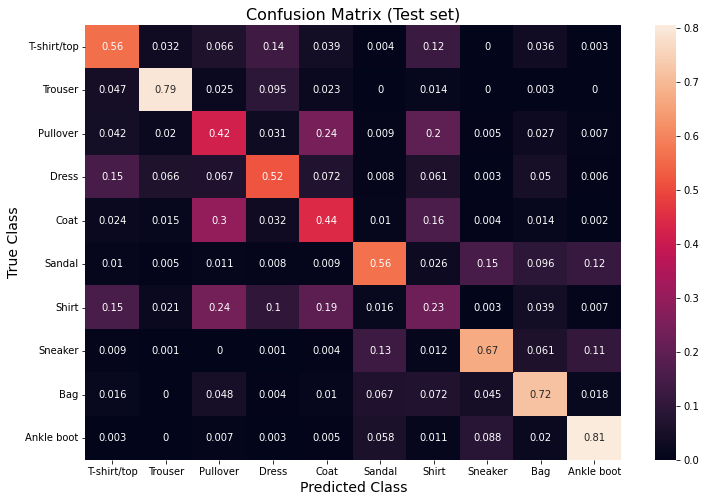

In [65]:
bern_cnf_matrix_test = confusion_matrix(y_test, y, normalize='true')
plt.figure(figsize=(12, 8))
ax = sns.heatmap(bern_cnf_matrix_test, annot=bern_cnf_matrix_test,xticklabels=class_names, yticklabels=class_names)
ax.set_title("Confusion Matrix (Test set)", size=16)
ax.set_xlabel("Predicted Class", size=14)
ax.set_ylabel("True Class", size=14)
plt.savefig("testmatrix")
plt.show()
img2 = plt.imread("testmatrix.png")
wandb.log({"Confusion Matrix - Test set": wandb.Image(img2)})

KeyboardInterrupt: ignored

Exception in thread NetStatThr:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_run.py", line 148, in check_network_status
    status_response = self._interface.communicate_network_status()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface.py", line 125, in communicate_network_status
    resp = self._communicate_network_status(status)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface_shared.py", line 388, in _communicate_network_status
    resp = self._communicate(req, local=True)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface_shared.py", line 213, in _communicate
    return self._communicate_async(rec, local=local).get(timeout=timeout)
  File "/usr/local/lib/python